# LDA (Latent Dirichlet Allocation) & LSI (Latent Semantic Indexing)

#### Set parameters for how final model results will be saved

In [1]:
tokenized_run_name = "weighted_nowiki_1_tokens"  #manually input the filename (no extension) to be used as input

In [2]:
data_directory = "../data/"
output_directory = "../outputs/"

In [3]:
base_model_type = "lda_lsi"
model_name_suffix = ""  #default should be blank; use to make note of any other mods
run_number = 2

In [4]:
final_model_name = f"{base_model_type}_{tokenized_run_name[:-7]}_run{run_number}{model_name_suffix}"

#### Imports

In [5]:
# general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # for LDA modeling & presentation
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# # for LSA modeling
from sklearn.decomposition import TruncatedSVD

# for progress bar on loops
from tqdm import tqdm

#### Read in Dataframe with tokenized text

In [6]:
df = pd.read_csv(f"{data_directory}{tokenized_run_name}.csv")
df.head()

,name,href,tokenized_text
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...


In [7]:
df.isna().sum()

name              0
href              0
tokenized_text    0
dtype: int64

In [8]:
df.fillna("",inplace=True)

#### Count Vectorization & TfIDF

In [9]:
# Function draws heavily from Jiamei Wang's code: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def make_tfidf(input_df, text_colname='tokenized_text'):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        
    OUTPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    docs_raw = input_df[text_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    cvec = CountVectorizer(strip_accents = 'unicode',
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                            max_df = 0.5,                        # discard words that appear in > 50% of the reviews
                            min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**cvec.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} non-unique words in {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], text_colname, dtm_tfidf.shape[1]))
    
    # return tf_vectorizer, tfidf_vectorizer, dtm_tfidf
    return tfidf_vectorizer, dtm_tfidf

In [10]:
tfidf_vectorizer, dtm_tfidf = make_tfidf(df, 'tokenized_text')

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (2484, 1784), meaning that there are 2484 non-unique words in tokenized_text and 1784 tokens made through the filtering process.


#### Grid Search for best LDA model

In [11]:
# Define Grid Search Parameters
search_params = {'n_components': [5, 10, 20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

In [12]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_gridsearch(dtm_tfidf, search_params):
    '''
    INPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        model_gs - the GridSearchCV object
        best_lda_model - the best model, as determined by the grid search
    '''

    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model_gs = GridSearchCV(lda, param_grid=search_params, n_jobs=8, verbose=3)

    # Do the Grid Search
    model_gs.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model_gs.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model_gs.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model_gs.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    return model_gs, best_lda_model

In [13]:
model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Model Log Likelihood Score:  -17137.121113846293
Model Perplexity:  2139.9303203456197


#### Plotting LDA model performance

In [14]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_plot_performance(model_gs, search_params):
    ''' 
    INPUTS:
        model_gs - the GridSearchCV object
        
    OUTPUTS:
        A graph comparing LDA Model Performance Scores with different params
    '''

    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelihoods from Grid Search Output
    gscore=model_gs.cv_results_

    log_likelihoods = {}
    for i in search_params['learning_decay']:
        log_likelihoods[i] = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==i]

    # Show graph
    plt.figure(figsize=(12, 8))
    for i in log_likelihoods:
        plt.plot(search_params['n_components'], log_likelihoods[i], label=i)
 
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return

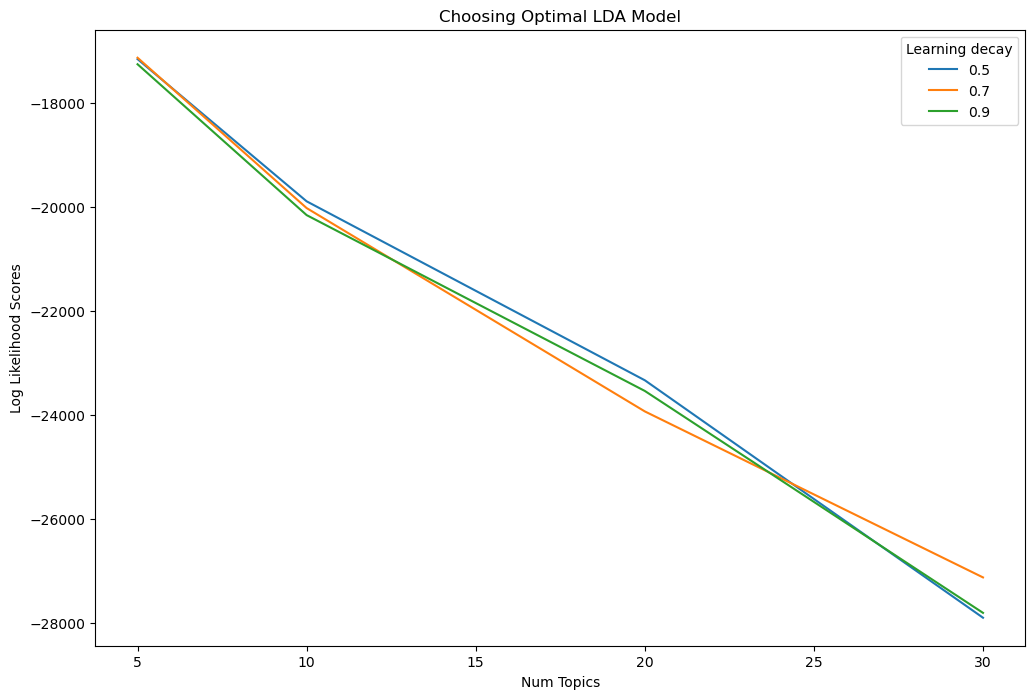

In [15]:
lda_plot_performance(model_gs, search_params)

#### (optional) Combined function for creating "best" LDA model with performance plot

In [16]:
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for more convenient parameter tuning)
# Once tuned/optimized, all 3 sub-functions can be run together in one command, wholly recreating the method used in the source referenced above

def optimal_lda_model(input_df, text_colname, search_params):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        best_lda_model - the best model, as determined by the grid search
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    
    tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
    model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)
    lda_plot_performance(model_gs, search_params)

    return best_lda_model, dtm_tfidf, tfidf_vectorizer

In [17]:
# (Same as above, in one single function call)

# best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df, 'combined_text', search_params)

#### Display topic keywords & weights

In [18]:
# Function excerpted directly with no additional modifications from: (Jiamei Wang)
# https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in tqdm(enumerate(model.components_)):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [19]:
lda_topic_words = display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words.head(10)

5it [00:00, 4990.84it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,documentary,42.3,animation,101.0,crime,127.6,comedy,137.9,fantasy,64.8
1,sport,24.4,adventure,79.4,mystery,64.7,romance,74.1,horror,45.3
2,reality,22.6,action,69.1,thriller,56.2,family,74.0,adventure,36.3
3,competition,12.1,anime,42.2,police,46.2,sitcom,48.4,sci,35.3
4,gay,11.7,base,33.1,murder,45.6,school,33.5,base,33.1
5,sports,11.4,history,32.7,investigation,42.7,music,29.0,action,31.5
6,war,9.5,superhero,29.5,detective,41.9,relationship,27.7,supernatural,30.0
7,football,9.2,historical,26.9,base,35.9,friendship,26.1,space,27.4
8,history,8.4,manga,25.1,novel,30.9,talk,22.3,alien,23.2
9,nature,7.2,comedy,23.5,book,28.7,teen,21.5,power,20.9


#### Visualizing LDA output with the pyLDAvis library

In [20]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.009884 -0.194780       1        1  24.881969
3     -0.171810  0.076822       2        1  24.216156
1      0.092606  0.070328       3        1  22.726019
4      0.145160  0.036930       4        1  19.746252
0     -0.056072  0.010700       5        1   8.429604, topic_info=             Term        Freq       Total Category  logprob  loglift
377         crime  107.000000  107.000000  Default  30.0000  30.0000
475   documentary   54.000000   54.000000  Default  29.0000  29.0000
77      animation  105.000000  105.000000  Default  28.0000  28.0000
311        comedy  150.000000  150.000000  Default  27.0000  27.0000
595       fantasy   62.000000   62.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
261       chicago    3.509068    7.444049   Topic5  -5.3494   1.7214
673          game    4.889182   23.752076   Topic5  -5.0177   0.8928
1639       travel    4.438556   23.383534   Topic5  -5.1144   0.8117
1772        world    4.389181   29.454829   Topic5  -5.1256   0.5697
165     biography    3.615779   33.772700   Topic5  -5.3194   0.2391

[286 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
15        1  0.175555     action
15        3  0.555924     action
15        4  0.253579     action
15        5  0.009753     action
23        1  0.887092  addiction
...     ...       ...        ...
1772      5  0.135801      world
1780      1  0.310541       york
1780      2  0.659900       york
1780      4  0.038818       york
1783      4  0.901504     zombie

[413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])

#### Generate results (fit-transorm) from a LDA model and tfidf matrix

In [21]:
lda_results = best_lda_model.fit_transform(dtm_tfidf) 

#### Append the LDA topic % matches onto the results dataframe

In [22]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lda_topic_pct_cols(lda_results, df_to_append_to, name_prefix=""):
    
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lda_results[j]):
            df_to_append_to.loc[j, f"{name_prefix}lda_topic{i}_match_pct"] = topic
    return
        

In [23]:
make_lda_topic_pct_cols(lda_results, df)

100%|██████████| 2484/2484 [00:00<00:00, 4132.31it/s]


In [24]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.321324,0.140535,0.040050,0.458396,0.039696
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.046358,0.047109,0.045487,0.814542,0.046504
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.052263,0.046518,0.044699,0.440041,0.416480
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.047269,0.053660,0.046672,0.806060,0.046338
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.812958,0.046401,0.046462,0.047026,0.047153


In [25]:
df.shape

(2484, 8)

# LSA model

In [26]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/


# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_results = lsa.fit_transform(dtm_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [27]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

# Print the topics with their terms

def lsa_topics_out(tfidf_vectorizer, svd_object):
    terms = tfidf_vectorizer.get_feature_names_out()

    for index, component in enumerate(svd_object.components_):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

    return

In [28]:
lsa_topics_out(tfidf_vectorizer, lsa)

Topic 0:  ['comedy', 'animation', 'adventure', 'action', 'base', 'crime', 'family', 'romance', 'fantasy', 'novel']
Topic 1:  ['crime', 'mystery', 'murder', 'police', 'investigation', 'detective', 'thriller', 'documentary', 'novel', 'book']
Topic 2:  ['comedy', 'romance', 'family', 'sitcom', 'school', 'friendship', 'relationship', 'love', 'music', 'relationships']
Topic 3:  ['novel', 'base', 'book', 'romance', 'fantasy', 'horror', 'supernatural', 'school', 'vampire', 'love']
Topic 4:  ['documentary', 'history', 'biography', 'miniseries', 'war', 'true', 'historical', 'sport', 'romance', 'reality']
Topic 5:  ['fantasy', 'horror', 'family', 'anthology', 'documentary', 'supernatural', 'comedy', 'sci', 'space', 'alien']
Topic 6:  ['family', 'space', 'alien', 'action', 'sci', 'superhero', 'adventure', 'thriller', 'sitcom', 'comic']
Topic 7:  ['space', 'sci', 'alien', 'mystery', 'romance', 'thriller', 'travel', 'horror', 'animation', 'documentary']
Topic 8:  ['family', 'novel', 'book', 'animat

In [29]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lsa_topic_pct_cols(lsa_results, df_to_append_to):
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lsa_results[j]):
            df_to_append_to.loc[j, f"lsa_topic{i}_cos_match"] = topic
    return

In [30]:
make_lsa_topic_pct_cols(lsa_results, df)

100%|██████████| 2484/2484 [00:01<00:00, 2065.26it/s]


In [31]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct,lsa_topic0_cos_match,lsa_topic1_cos_match,lsa_topic2_cos_match,lsa_topic3_cos_match,lsa_topic4_cos_match,lsa_topic5_cos_match,lsa_topic6_cos_match,lsa_topic7_cos_match,lsa_topic8_cos_match,lsa_topic9_cos_match
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.321324,0.140535,0.040050,0.458396,0.039696,0.290799,0.034078,-0.156321,0.301677,0.042412,0.100093,0.012538,-0.111998,0.117763,-0.056992
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.046358,0.047109,0.045487,0.814542,0.046504,0.087384,0.079138,-0.054315,-0.056399,-0.003084,-0.022632,0.054539,-0.009584,-0.022123,0.053008
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.052263,0.046518,0.044699,0.440041,0.416480,0.145995,-0.037602,-0.101555,0.028280,0.121519,-0.001392,0.100740,-0.040454,0.082573,-0.063289
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.047269,0.053660,0.046672,0.806060,0.046338,0.332295,0.061431,-0.117450,-0.037261,-0.014104,-0.050870,0.127535,-0.318416,-0.193706,0.018731
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.812958,0.046401,0.046462,0.047026,0.047153,0.138292,-0.056398,-0.127264,0.017812,0.063516,0.099740,0.262287,0.233243,0.006338,-0.137644


In [32]:
df.shape

(2484, 18)

## Force LDA evaluate with different parameters

#### Generate same output items for forced alternate (20+ topic) model

In [33]:
# Define Grid Search Parameters
search_params2 = {'n_components': [20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 20}
Model Log Likelihood Score:  -23880.99128827867
Model Perplexity:  12644.347129646816


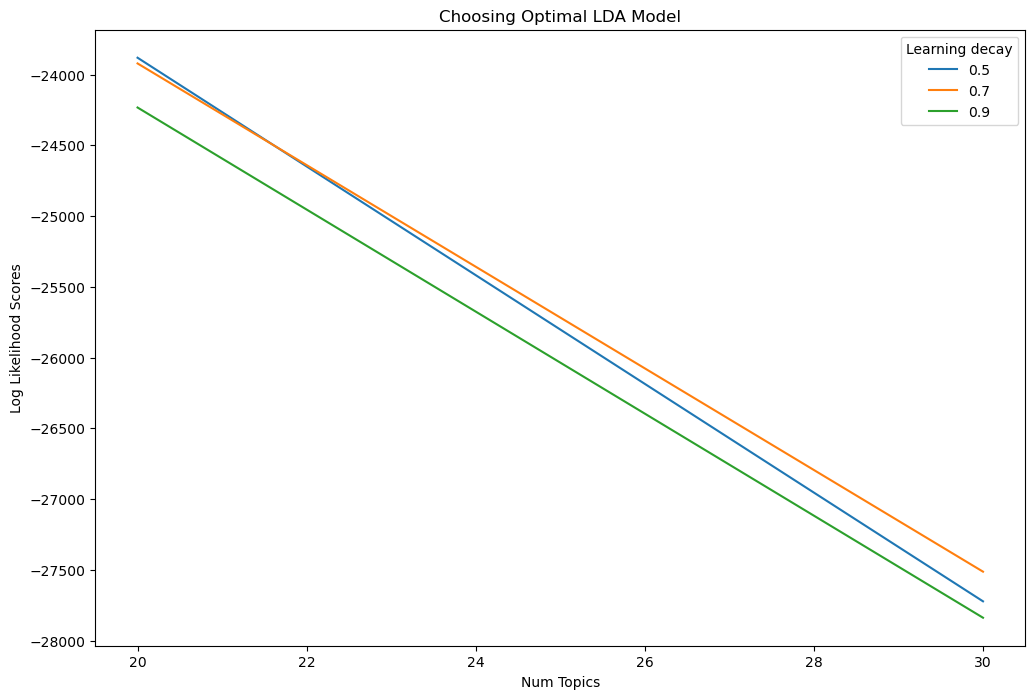

In [34]:
# tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
model_gs2, best_lda_model2 = lda_gridsearch(dtm_tfidf, search_params2)
lda_plot_performance(model_gs2, search_params2)

In [35]:
lda_topic_words2 = display_topics(best_lda_model2, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words2.head()

20it [00:00, 6618.75it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,...,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights,Topic 20 words,Topic 20 weights
0,politics,9.5,alien,17.9,horror,27.1,sport,23.9,space,32.5,...,history,31.3,short,20.5,crime,21.1,crime,81.4,florida,7.3
1,universe,8.4,documentary,14.1,anthology,18.8,sports,9.6,adventure,32.4,...,biography,22.7,spy,16.4,thriller,21.0,mystery,48.3,miami,4.2
2,usa,7.6,sci,10.5,mystery,13.6,football,9.1,animation,32.1,...,historical,12.6,animation,9.9,drug,8.5,murder,36.4,hotel,3.8
3,news,7.4,invasion,7.9,fbi,11.9,texas,6.3,comedy,20.9,...,post,12.2,action,7.9,police,8.1,thriller,34.0,religion,1.7
4,cinematic,7.0,robot,7.8,fantasy,11.5,mutant,6.3,action,16.7,...,war,11.1,apocalypse,7.1,drugs,7.8,investigation,30.9,irish,1.7


In [36]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model2, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.077700  0.128628       1        1  20.609500
18     0.205866  0.022715       2        1  11.251436
4     -0.095960  0.074381       3        1   6.800928
12    -0.143112  0.101346       4        1   6.500341
11     0.036205  0.090212       5        1   5.976695
10    -0.163741 -0.116963       6        1   5.892566
14    -0.155923 -0.080554       7        1   5.480221
9     -0.058874  0.227722       8        1   4.441224
17     0.167186 -0.032677       9        1   4.431918
2      0.200991  0.044559      10        1   4.336848
15     0.009833 -0.086904      11        1   3.845864
16    -0.004495  0.030544      12        1   3.393441
5      0.086815  0.055264      13        1   3.126149
1     -0.000395 -0.069135      14        1   2.934000
3     -0.033494 -0.009920      15        1   2.391226
13     0.047839 -0.083830      16        1   2.269598
0     -0.017278 -0.087523      17        1   2.081385
6      0.000334 -0.079253      18        1   1.595235
19     0.000293 -0.066127      19        1   1.363939
7     -0.004390 -0.062485      20        1   1.277485, topic_info=           Term        Freq       Total Category  logprob  loglift
377       crime  108.000000  108.000000  Default  30.0000  30.0000
77    animation  105.000000  105.000000  Default  29.0000  29.0000
311      comedy  148.000000  148.000000  Default  28.0000  28.0000
29    adventure   99.000000   99.000000  Default  27.0000  27.0000
759     history   41.000000   41.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1550   survival    0.500426   12.513782  Topic20  -5.4101   1.1411
889     landing    0.111621    2.465084  Topic20  -6.9105   1.2654
922        list    0.102247    2.161359  Topic20  -6.9982   1.3092
174       block    0.089628    1.837335  Topic20  -7.1299   1.3399
1604       time    0.094946   21.021208  Topic20  -7.0723  -1.0397

[913 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7         2  0.542182    abuse
7         7  0.135545    abuse
7        16  0.271091    abuse
8         4  0.397712  academy
15        1  0.301049   action
...     ...       ...      ...
1781      4  0.051767    young
1781      5  0.051767    young
1781      6  0.051767    young
1783     10  0.129645   zombie
1783     12  0.777869   zombie

[1422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 19, 5, 13, 12, 11, 15, 10, 18, 3, 16, 17, 6, 2, 4, 14, 1, 7, 20, 8])

In [37]:
lda_results2 = best_lda_model2.fit_transform(dtm_tfidf) 

In [38]:
make_lda_topic_pct_cols(lda_results2, df, "forced_alt_")

100%|██████████| 2484/2484 [00:02<00:00, 1014.78it/s]


## Save final results dataframe

> Saves only the results columns.  All other columns can be obtained from prior dataframes

In [39]:
df.columns

Index(['name', 'href', 'tokenized_text', 'lda_topic0_match_pct',
       'lda_topic1_match_pct', 'lda_topic2_match_pct', 'lda_topic3_match_pct',
       'lda_topic4_match_pct', 'lsa_topic0_cos_match', 'lsa_topic1_cos_match',
       'lsa_topic2_cos_match', 'lsa_topic3_cos_match', 'lsa_topic4_cos_match',
       'lsa_topic5_cos_match', 'lsa_topic6_cos_match', 'lsa_topic7_cos_match',
       'lsa_topic8_cos_match', 'lsa_topic9_cos_match',
       'forced_alt_lda_topic0_match_pct', 'forced_alt_lda_topic1_match_pct',
       'forced_alt_lda_topic2_match_pct', 'forced_alt_lda_topic3_match_pct',
       'forced_alt_lda_topic4_match_pct', 'forced_alt_lda_topic5_match_pct',
       'forced_alt_lda_topic6_match_pct', 'forced_alt_lda_topic7_match_pct',
       'forced_alt_lda_topic8_match_pct', 'forced_alt_lda_topic9_match_pct',
       'forced_alt_lda_topic10_match_pct', 'forced_alt_lda_topic11_match_pct',
       'forced_alt_lda_topic12_match_pct', 'forced_alt_lda_topic13_match_pct',
       'forced_alt_ld

In [40]:
# (default) if reading from a tokenized-only df
columns_to_drop = ['tokenized_text']

# for cases run using other (non-standard) df's as input
#columns_to_drop = ['combined_text', 'lemmatized_text', 'tokenized_text']

In [41]:
df.drop(columns=columns_to_drop, inplace=True)

In [42]:
df.to_csv(f"{output_directory}{final_model_name}.csv", index=False)
# df.to_json(f"{output_directory}{final_model_name}.json")

#### Save topic words matrices

In [43]:
lda_topic_words.to_csv(f"{output_directory}{final_model_name}_topicwords.csv", index=False)

In [44]:
lda_topic_words2.to_csv(f"{output_directory}{final_model_name}_topicwords_forced_alt.csv", index=False)